In [1]:
%matplotlib inline
import sys
import os
sys.path.append('/home/kihyun/data/projects/kihyun/Editing-benchmark/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
from tqdm import tqdm
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
dataDir='/home/kihyun/data/dataset/COCO2017'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
json_dir = '/home/kihyun/data/projects/kihyun/Editing-benchmark/edit_task_v2.json'
catnms = ['person', 'dog', 'cat'] # 해당 object가 모두 있는 이미지만 선택 및 프롬프트 저장
Annotation = True # Annotation mask를 이미지에 표시할지 여부
save_dir = './img_above_certain_size_bbox' # 프롬프트 저장 위치
save_img = True
img_num = 30

In [3]:
cat_dir = '_'.join(catnms) # 프롬프트 저장 위치
save_path = os.path.join(save_dir, cat_dir)
if not os.path.exists(save_path):
        os.makedirs(save_path)

In [4]:
# initialize COCO api for instance annotations
# annotation file을 읽어서 COCO object를 생성
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [13]:
# def img_idx_list(coco, catnms): # catnms = ['person', 'dog'] 에 해당하는 이미지들의 id를 반환
#     catIds = coco.getCatIds(catNms=catnms)
#     imgIds = coco.getImgIds(catIds=catIds)
#     print("Number of images containing all of the categories: ", len(imgIds))
#     return len(imgIds), imgIds

def img_idx_list(coco):
    imgIds = coco.getImgIds()
    print("Number of images in the dataset: ", len(imgIds))
    return len(imgIds), imgIds

def img_show(coco, imgId, mask=False, catnms=None, save_path=save_path, save = save_img):
    img = coco.loadImgs(imgId)[0]
    I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    #I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    if mask:
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
        anns = coco.loadAnns(annIds)
        coco.showAnns(anns)
    if save:
        save_name = f'{imgId}.jpg'
        img_path = os.path.join(save_path, save_name)
        plt.savefig(img_path)
        plt.close()
    
def multi_img_show(coco, imgId_ls, mask=False, catnms=None, save_num = img_num):
    count = 0
    # print(f'Number of images downloaded: {save_num}')
    for i, imgId in enumerate(tqdm(imgId_ls[:100], desc="Downloading images")):
        # if i == save_num:
        #     break
        # img_show(coco, imgId, mask)
        image_summary = calculate_image_summary(coco, [imgId])
        if image_summary:
            # img_show(coco, imgId, mask)
            count += 1
    return count
        
def save_edit_prompts(json_dir, save_path=save_path):
    # read json file
    with open(json_dir, 'r') as f:
        json_data = json.load(f)
    # save edit prompts in prompt_save_dir
   
    file_name = f'edit_prompts_{catnms}.txt'
    txt_path = os.path.join(save_path, file_name)
    ff = open(txt_path, 'w')
    for cat in catnms:
        for edit_task in json_data[cat].keys():
            for subtask in json_data[cat][edit_task]['to']:
                ff.write(f'{cat}, {edit_task}, {subtask}\n')
                ff.write('---------------------\n')
    # ff.close()

def calculate_image_summary(coco, imgId_ls):
    category_info = {}  # {category_name: [count, total_area]}

    for imgId in imgId_ls:
        annIds = coco.getAnnIds(imgIds=imgId)
        anns = coco.loadAnns(annIds)
        for ann in anns:
            category_name = coco.loadCats(ann['category_id'])[0]['name']
            bbox = ann['bbox']  # [x, y, width, height]
            width, height = bbox[2], bbox[3]
            area = width * height
            if area < 1000:
                print(imgId)
                return None
            if category_name not in category_info:
                category_info[category_name] = [0]
            category_info[category_name][0] += 1
            category_info[category_name].append(area)

    image_summary = {cat: info for cat, info in category_info.items()}
    return image_summary
    
def show_cat_imgs_n_prompt(coco, json_dir):
    n, imgId_ls = img_idx_list(coco)
    i = multi_img_show(coco, imgId_ls, mask=Annotation)
    # save_edit_prompts(catnms, json_dir)   # 일단 이미지만 체크
    return i

def process_single_image(coco, imgId, json_dir):
    img_show(coco, imgId, mask=Annotation)
    image_summary = calculate_image_summary(coco, imgId)
    print(image_summary)
    return image_summary

Calculating category summary: 100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]

{'dog': [1, 320.5421], 'couch': [3, 36259.3422, 9858.497, 25141.8904], 'chair': [3, 17009.2164, 25439.229000000003, 10269.904999999999], 'dining table': [1, 9629.8258], 'bottle': [1, 314.68399999999997], 'cup': [3, 70.605, 55.198, 20.418]}


{'dog': [1, 320.5421],
 'couch': [3, 36259.3422, 9858.497, 25141.8904],
 'chair': [3, 17009.2164, 25439.229000000003, 10269.904999999999],
 'dining table': [1, 9629.8258],
 'bottle': [1, 314.68399999999997],
 'cup': [3, 70.605, 55.198, 20.418]}

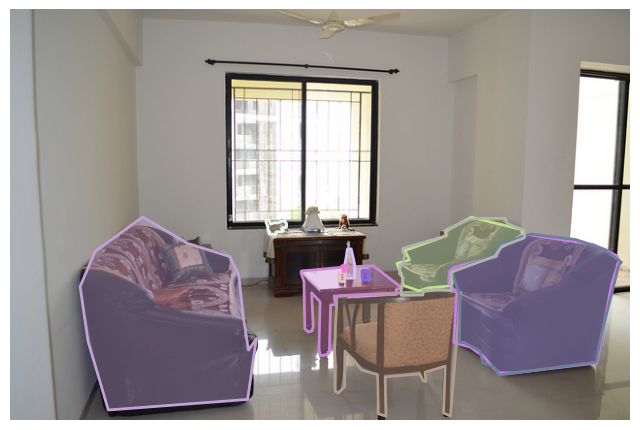

In [19]:
# image_summary = process_single_image(coco, [98304], json_dir)
# image_summary

In [12]:
i = show_cat_imgs_n_prompt(coco, json_dir)
i

Number of images in the dataset:  5000


397133
37777
252219
87038
174482
480985
296649
386912
491497
184791
348881
522713
181666
17627
303818
463730
460347
322864
565778
500663
239274
286994
511321
233771
185250
516316
562121
16228
430961
448365
349860
400573
370677
515579
515445
438862
474028
239347
78915


99